# Инженерка

## Подготовка данных

Получаем типы физических объектов

In [15]:
import requests
import pandas as pd

res = requests.get('http://10.32.1.107:5300/api/v1/physical_object_types')
physical_objects_types = pd.DataFrame(res.json()).set_index('physical_object_type_id', drop=True)
# physical_objects_types.to_excel('pot.xlsx')
physical_objects_types.head()

,name,physical_object_function
physical_object_type_id,,
1,Рекреационная зона,None
2,Водный объект,None
3,Зеленая зона,None
4,Жилой дом,None
5,Здание,None


Типы индикаторов

In [28]:
res = requests.get('http://10.32.1.107:5300/api/v1/indicators_by_parent', {'get_all_subtree':True})
indicators = pd.DataFrame(res.json()).set_index('indicator_id', drop=True)
indicators.head()

,name_full,name_short,measurement_unit,level,list_label,parent_id,created_at,updated_at
indicator_id,,,,,,,,
261,Расчет обеспеченности,Расчет обеспеченности,None,1,5,NaN,2024-10-02T06:28:21.885235Z,2024-10-02T06:28:21.885235Z
34,Демография,Демография,None,1,2,NaN,2024-10-02T06:28:21.885235Z,2024-10-02T06:28:21.885235Z
46,Транспорт,Транспорт,None,1,3,NaN,2024-10-02T06:28:21.885235Z,2024-10-02T06:28:21.885235Z
135,Экология,Экология,None,1,6,NaN,2024-10-02T06:28:21.885235Z,2024-10-02T06:28:21.885235Z
178,Социальные риски,Социальные риски,None,1,8,NaN,2024-10-02T06:28:21.885235Z,2024-10-02T06:28:21.885235Z


Маппинг индикаторов и типов физ объектов

In [29]:
INDICATORS_POTS = {
  88: [],
  89: [21, 33, 34, 35],
  90: [38, 40],
  91: [37, 39],
  92: [],
  93: [],
}

Тогда необходимые физ объекты выглядят так

In [48]:
PHYSICAL_OBJECTS_IDS = {pot_id for ind_id, ind_pots in INDICATORS_POTS.items() for pot_id in ind_pots}
PHYSICAL_OBJECTS_IDS

{21, 33, 34, 35, 37, 38, 39, 40}

In [46]:
for ind_id, pots_ids in INDICATORS_POTS.items():
  print(indicators.loc[ind_id, 'name_full'] + ':')
  print(str.join('\r\n', ['- ' + physical_objects_types.loc[pot_id, 'name'] for pot_id in pots_ids]))
  print('\r\n')

Количество объектов инженерной инфраструктуры:



Количество электростанций (ТЭС, АЭС и пр.):
- Электростанция
- Ветрогенератор
- Гидроэлектростанция
- Атомная электростанция


Количество больших водозаборов:
- Водонапорная башня
- Водозаборное сооружение


Количество очистительных сооружений:
- Сооружение для очистки воды
- Водоочистное сооружение


Количество крупных водохранилищ:



Количество газораспределительных станций:





Получаем территории

In [38]:
import geopandas as gpd

def get_region_territories(region_id : int):
    res = requests.get('http://10.32.1.107:5300' + '/api/v1/all_territories', {
        'parent_id': region_id,
        'get_all_levels': True
    })
    gdf = gpd.GeoDataFrame.from_features(res.json()['features'], crs=4326)
    df = pd.json_normalize(gdf['territory_type']).rename(columns={
        'name':'territory_type_name'
    })
    gdf = pd.DataFrame.join(gdf, df).set_index('territory_id', drop=True)
    return {level:gdf[gdf['level'] == level] for level in set(gdf.level)}

In [41]:
gdfs = get_region_territories(1)

In [42]:
levels = gdfs.keys()

dict_keys([3, 4, 5])

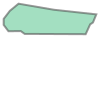

In [5]:
import geopandas as gpd

region_id = 1
polygon = gpd.read_file('./data/territories/shlis.geojson').iloc[0].geometry
polygon